In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, LogFormatter, MultipleLocator
import matplotlib.dates as mdates
from matplotlib.animation import FuncAnimation
import numpy as np

url_confirmed = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
url_deadths = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
url_recovereds = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'

In [23]:
df_confirmed = pd.read_csv(url_confirmed)
df_deadths = pd.read_csv(url_deadths)
df_recovereds_df = pd.read_csv(url_recovereds)

In [24]:
def data_for_country(country):
    data = pd.DataFrame()
    country_confirmed_df = df_confirmed[df_confirmed['Country/Region'] == country]

    country_confirmed_df = country_confirmed_df.drop(['Province/State', 'Lat', 'Long', 'Country/Region'], axis=1)
    country_confirmed_df = country_confirmed_df.T
    country_confirmed_df.index = pd.to_datetime(country_confirmed_df.index)
    country_confirmed_df = pd.DataFrame(country_confirmed_df.sum(axis=1))
    # display(country_confirmed_df)
    #    display(country_confirmed_df.sum(axis=1))
    country_confirmed_df.columns = [country]
    data['Confirmados'] = country_confirmed_df[country]

    country_recovereds_df = df_recovereds_df[df_recovereds_df['Country/Region'] == country]
    country_recovereds_df = country_recovereds_df.drop(['Province/State', 'Lat', 'Long', 'Country/Region'], axis=1)
    country_recovereds_df = country_recovereds_df.T
    country_recovereds_df.index = pd.to_datetime(country_recovereds_df.index)
    country_recovereds_df = pd.DataFrame(country_recovereds_df.sum(axis=1))
    country_recovereds_df.columns = [country]
    data = pd.concat([data, country_recovereds_df[country]], axis=1, sort=False)

    country_deadths_df = df_deadths[df_deadths['Country/Region'] == country]
    country_deadths_df = country_deadths_df.drop(['Province/State', 'Lat', 'Long', 'Country/Region'], axis=1)
    country_deadths_df = country_deadths_df.T
    country_deadths_df.index = pd.to_datetime(country_deadths_df.index)
    country_deadths_df = pd.DataFrame(country_deadths_df.sum(axis=1))
    country_deadths_df.columns = [country]
    data = pd.concat([data, country_deadths_df[country]], axis=1, sort=False)

    data.columns = ['Confirmados', 'Recuperados', 'Muertos']
    data['Infectados'] = data['Confirmados'] - data['Recuperados'] - data['Muertos']
    # display(data.head())

    return data


In [25]:

spain_df = pd.DataFrame()
spain_df = data_for_country('Spain')
italia_df = data_for_country('Italy')
china_df = data_for_country('China')
germany_df = data_for_country('Germany')
francia_df = data_for_country('France')
eeuu_df = data_for_country('US')
uk_df = data_for_country('United Kingdom')

#display(spain_df['Confirmed'].head())
#display(spain_deadths_df.head())
#eeuu_df.tail(20)

In [54]:
def generate_info_text(country_df):
    confirmados= country_df['Confirmados'].iloc[-1]
    incremento_confirmados = confirmados-country_df['Confirmados'].iloc[-2]
    recuperados= country_df['Recuperados'].iloc[-1]
    incremento_recuperados = recuperados-country_df['Recuperados'].iloc[-2]
    muertes= country_df['Muertos'].iloc[-1]
    incremento_muertes = muertes-country_df['Muertos'].iloc[-2]
    infectados= country_df['Infectados'].iloc[-1]
    incremento_infectados = infectados-country_df['Infectados'].iloc[-2]
    fecha = country_df.index[-1]
    
    texto = f'Total Confirmados: {int(confirmados):>6} ({int(incremento_confirmados)}) \n'\
            f'Total Recuperados: {int(recuperados):>6} ({int(incremento_recuperados)})\n'\
            f'Total Muertes: {int(muertes):>6} ({int(incremento_muertes)})\n'\
            f'Infectados Actuales: {int(infectados):>6} ({int(incremento_infectados)})\n'\
            f'Actualización: {fecha.strftime("%d %b %Y")}'
    return texto


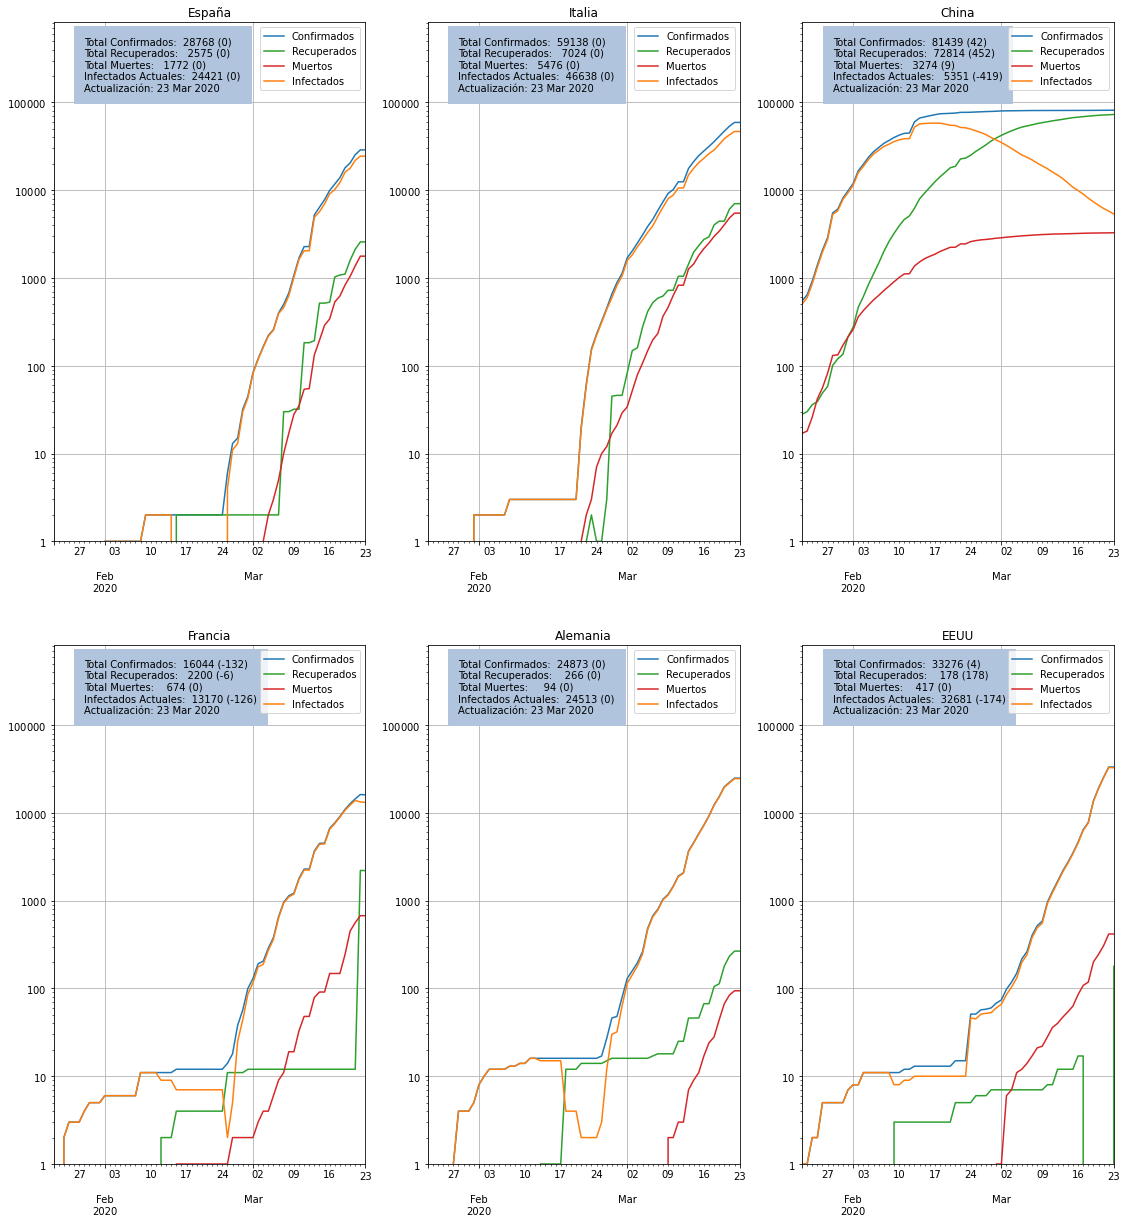

In [55]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(19, 21))
#print(axes)
titles = ['España', 'Italia', 'China', 'Francia', 'Alemania', 'EEUU', 'UK']
data = [spain_df, italia_df, china_df, francia_df, germany_df, eeuu_df, uk_df]

max_y = china_df['Confirmados'].max()*10

pais_id = 0
for rox_ax in axes:
    for column_ax in rox_ax:
        data[pais_id].plot(ax=column_ax, color=['#1F77B4','#2CA02C','#D62728','#FF7F0E'])
        column_ax.set_title(titles[pais_id])
        column_ax.set_yscale('log')
        column_ax.set_ylim(1, max_y)
        column_ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        column_ax.legend()
        column_ax.grid()
        column_ax.text('1/28/2020',max_y/6, generate_info_text(data[pais_id]),
                       bbox=dict(boxstyle="square",
                                 ec='lightsteelblue',
                                 facecolor='lightsteelblue',
                                 pad= 1,
                                ))
        pais_id +=1
    
fig.savefig('test.png')


# Datos por Paises

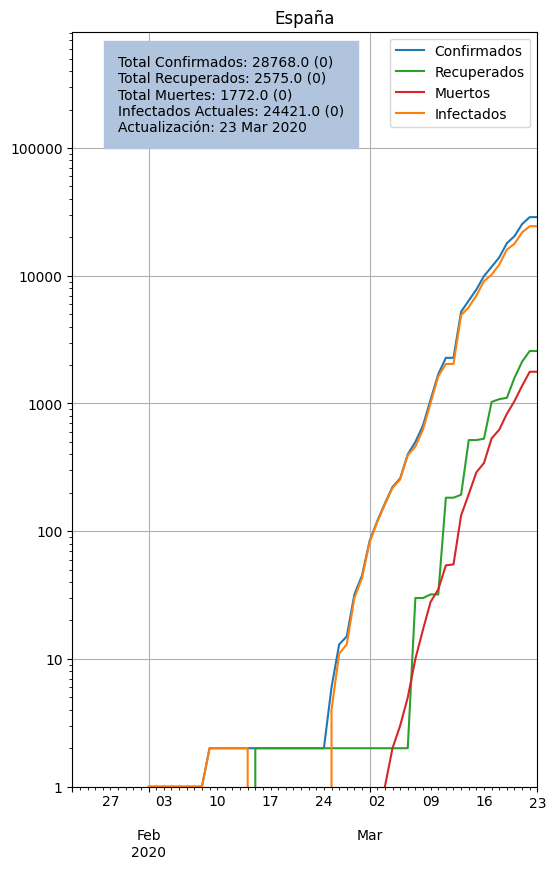

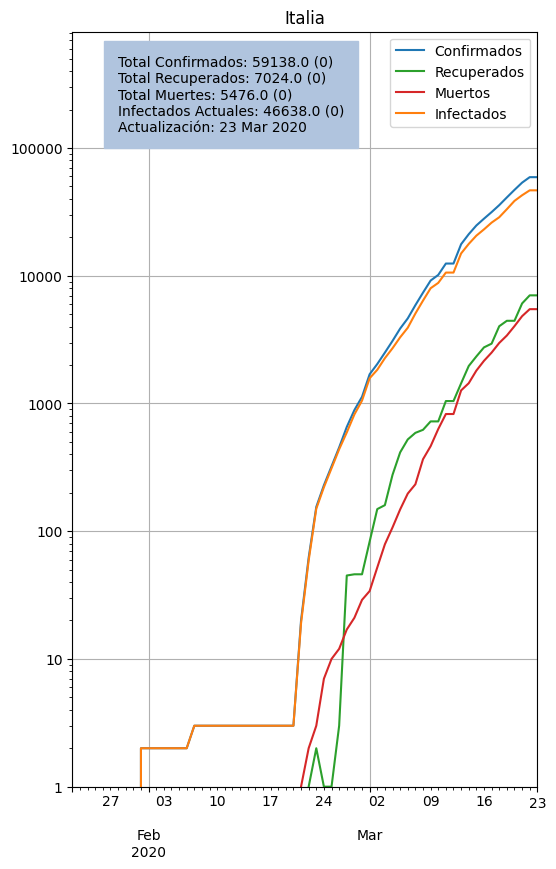

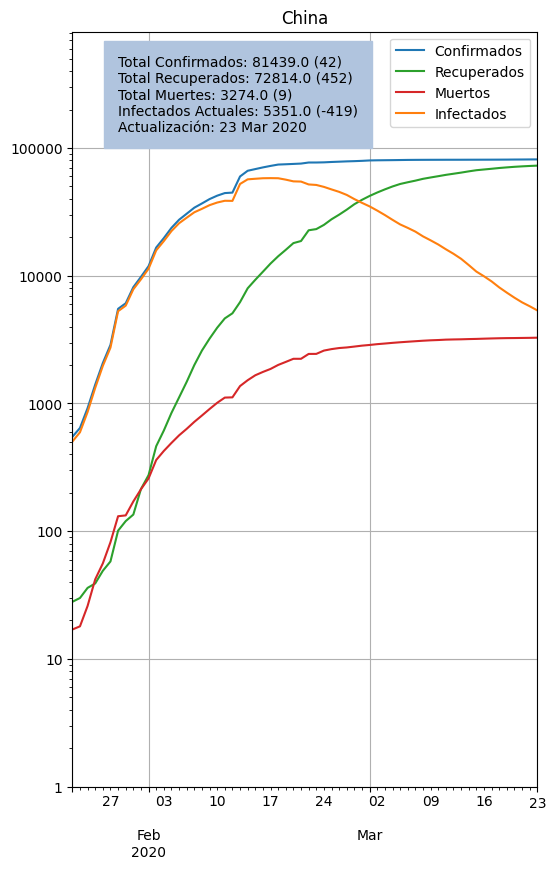

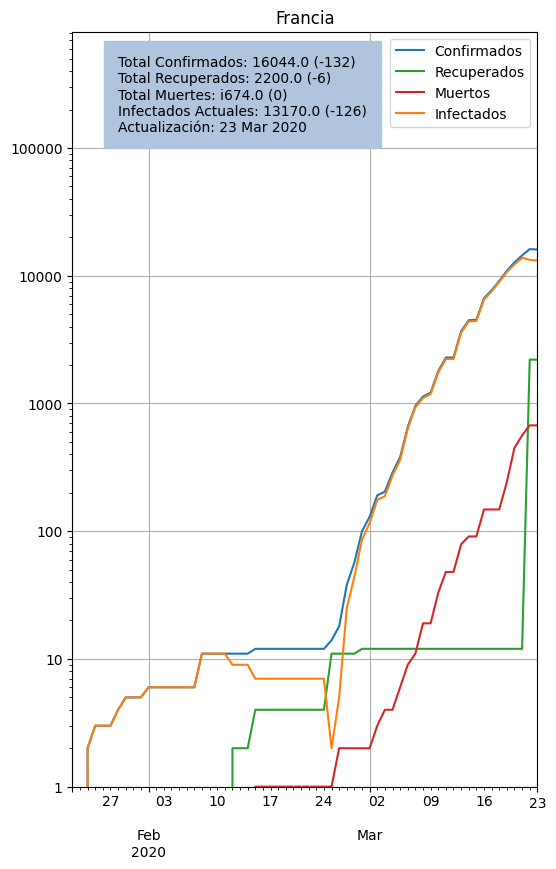

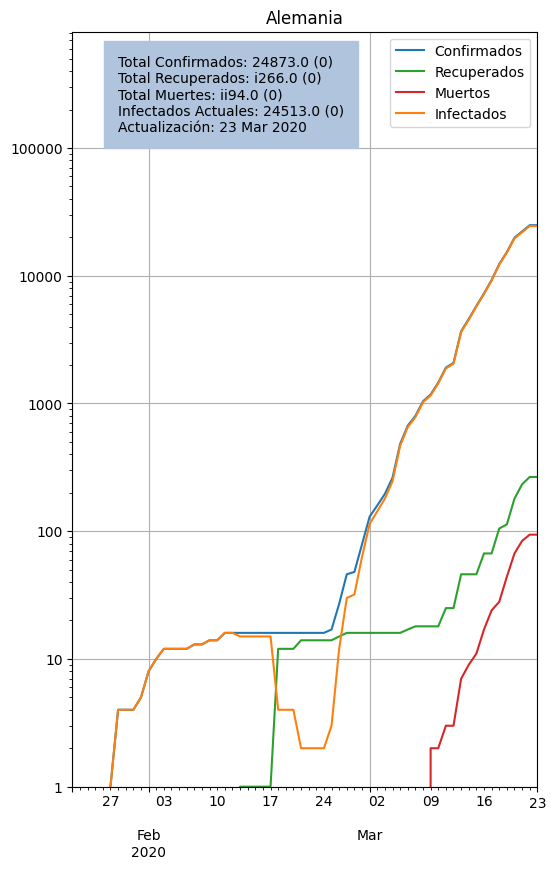

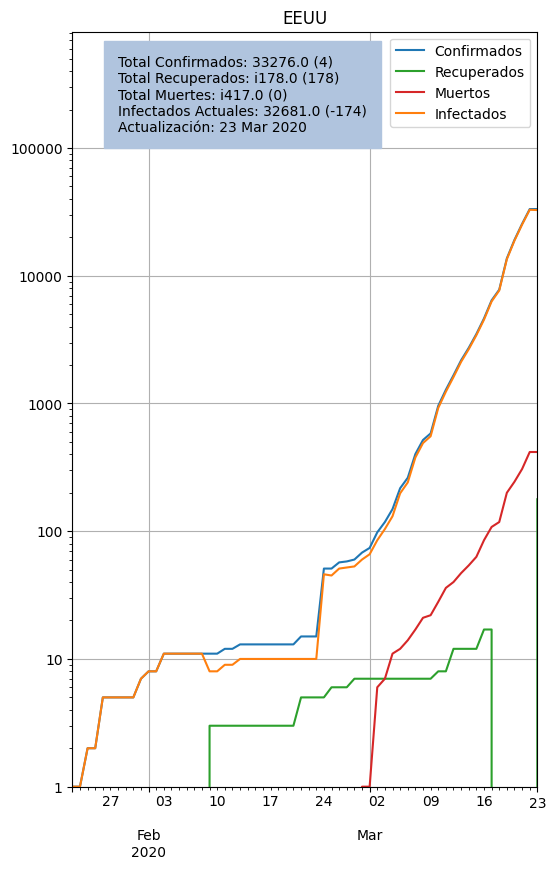

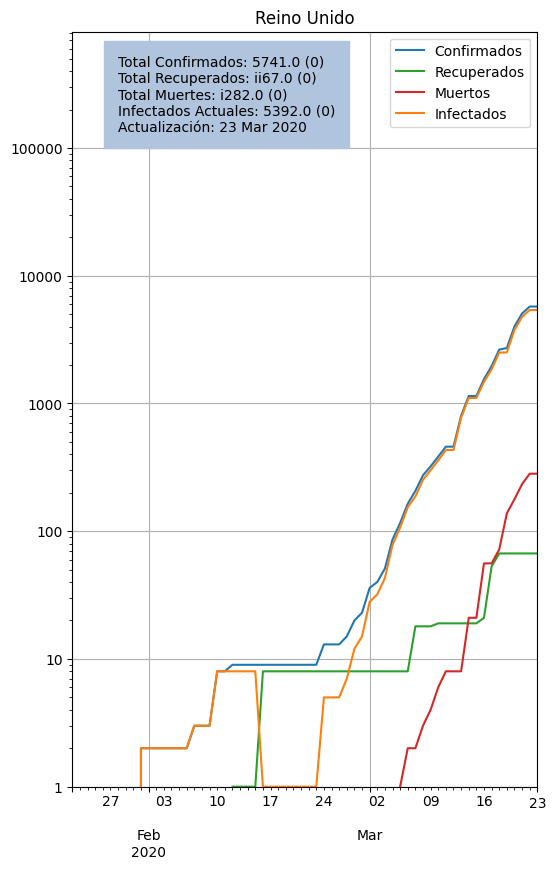

In [53]:

pais_id = 0
for country_df in data:
    fig = plt.figure(figsize=(6,10), dpi=100)
    ax = fig.add_subplot(1, 1, 1)
    country_df.plot(ax=ax, color=['#1F77B4','#2CA02C','#D62728','#FF7F0E'])
    if (titles[pais_id]=="UK"):
        title = 'Reino Unido'
    else:
        title = titles[pais_id]
            

    ax.set_title(title)
    ax.set_yscale('log')
    ax.set_ylim(1, max_y)
    ax.yaxis.set_major_formatter(ScalarFormatter())
    ax.legend(loc='best')
    ax.grid()    
    ax.text('1/28/2020',max_y/6, generate_info_text(country_df),          
            bbox=dict(boxstyle="square",
                   ec='lightsteelblue',
                   facecolor='lightsteelblue',
                   pad= 1,
                   ))
    
    
    fig.savefig(f'{titles[pais_id]}-test.png')
    pais_id +=1

# Comparativas


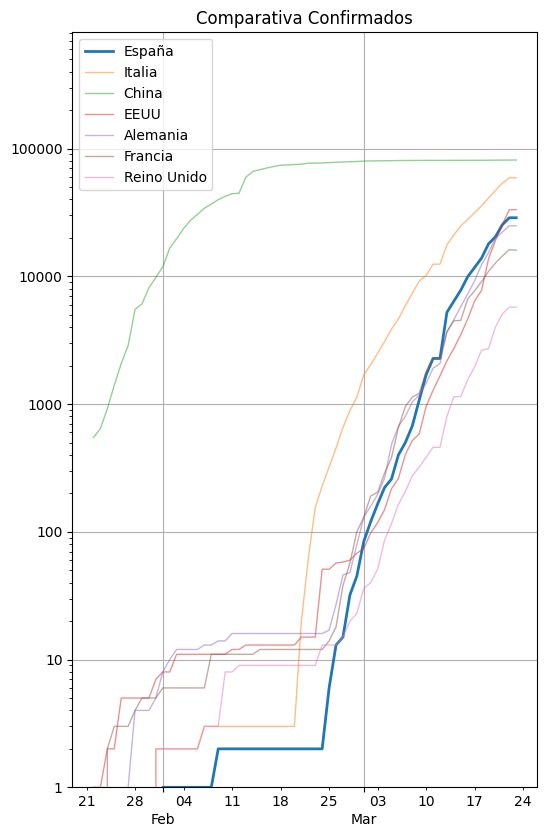

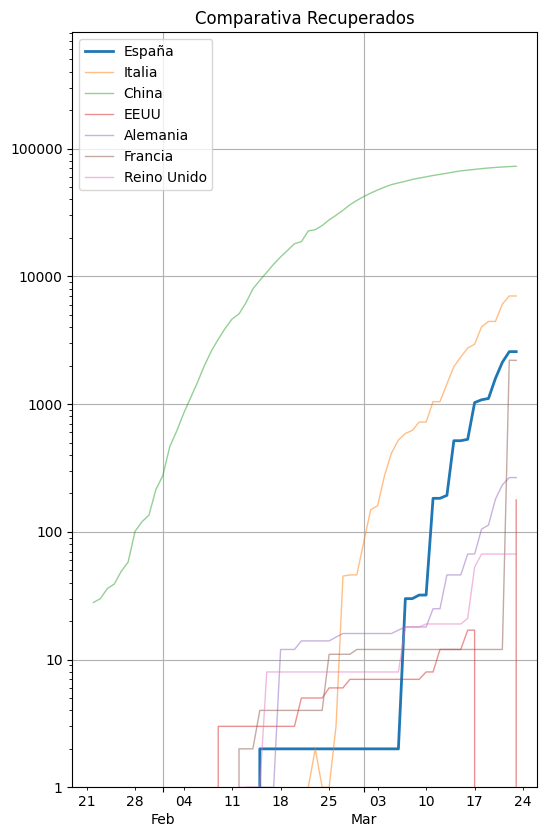

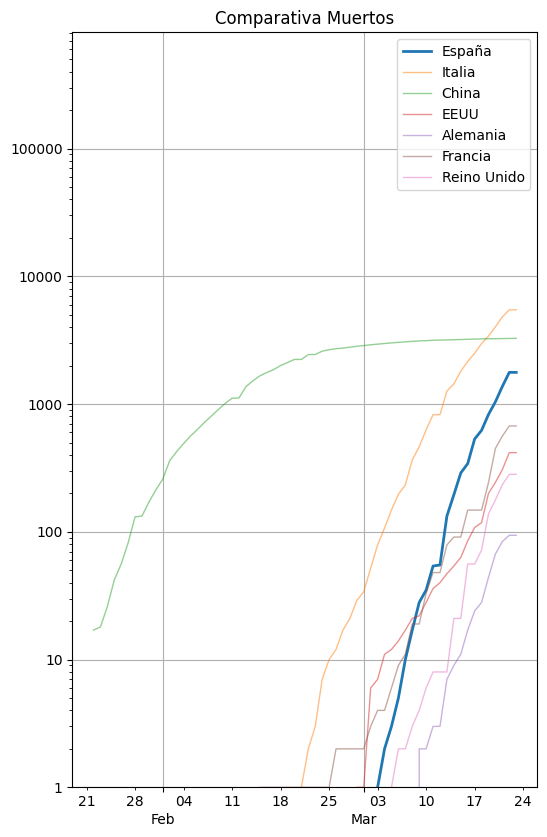

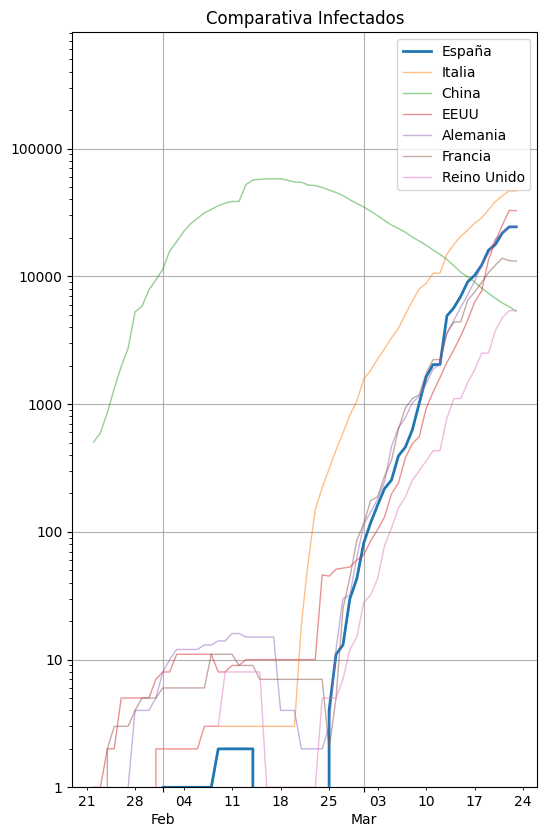

In [8]:
estados =['Confirmados', 'Recuperados', 'Muertos', 'Infectados']
for estado in estados:
    fig = plt.figure(figsize=(6,10), dpi=100)
    ax = fig.add_subplot(1, 1, 1)
    
    ax.plot(spain_df[estado], label='España',linewidth=2)
    ax.plot(italia_df[estado], label='Italia',linewidth=1, alpha = 0.5)
    ax.plot(china_df[estado], label='China',linewidth=1, alpha = 0.5)
    ax.plot(eeuu_df[estado], label='EEUU',linewidth=1, alpha = 0.5)
    ax.plot(germany_df[estado], label='Alemania',linewidth=1, alpha = 0.5)
    ax.plot(francia_df[estado], label='Francia',linewidth=1, alpha = 0.5)
    ax.plot(uk_df[estado], label='Reino Unido',linewidth=1, alpha = 0.5)
    
    ax.set_title(f'Comparativa {estado}')
    ax.set_yscale('log')
    ax.set_ylim(1, max_y)
    ax.yaxis.set_major_formatter(ScalarFormatter())
    ax.xaxis.set_major_formatter(ScalarFormatter())

    #set major ticks format
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%d'))
    ax.xaxis.set_minor_locator(mdates.WeekdayLocator())
    xax = ax.get_xaxis()
    xax.set_tick_params(which='major', pad=15)
    
    
    ax.legend(loc='best')
    ax.grid()    
    
    fig.savefig(f'comparativa_{str(estado)}.png')

# Animacion

timestep 0
timestep 1
timestep 2
timestep 3
timestep 4
timestep 5
timestep 6
timestep 7
timestep 8
timestep 9
timestep 10
timestep 11
timestep 12
timestep 13
timestep 14
timestep 15
timestep 16
timestep 17
timestep 18
timestep 19
timestep 20
timestep 21
timestep 22
timestep 23
timestep 24
timestep 25
timestep 26
timestep 27
timestep 28
timestep 29
timestep 30
timestep 31
timestep 32
timestep 33
timestep 34
timestep 35
timestep 36
timestep 37
timestep 38
timestep 39
timestep 40
timestep 41
timestep 42
timestep 43
timestep 44
timestep 45
timestep 46
timestep 47
timestep 48
timestep 49
timestep 50
timestep 51
timestep 52
timestep 53
timestep 54
timestep 55
timestep 56
timestep 57
timestep 58
timestep 59
timestep 60


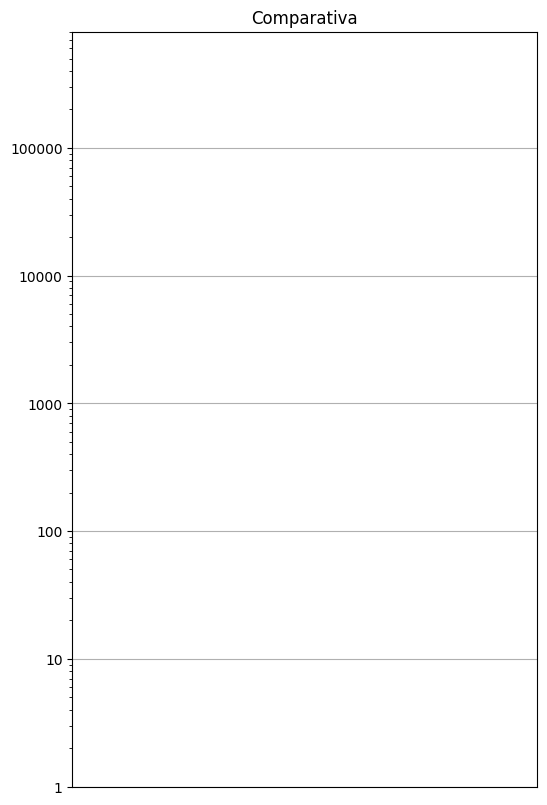

In [13]:
fig = plt.figure(figsize=(6,10), dpi=100)
ax = plt.axes(xlim=(0, 4), ylim=(-2, 2))

#ax.plot(spain_df[estado], label='España',linewidth=2)
#ax.plot(italia_df[estado], label='Italia',linewidth=1, alpha = 0.5)
#ax.plot(china_df[estado], label='China',linewidth=1, alpha = 0.5)
#ax.plot(eeuu_df[estado], label='EEUU',linewidth=1, alpha = 0.5)
#ax.plot(germany_df[estado], label='Alemania',linewidth=1, alpha = 0.5)
#ax.plot(francia_df[estado], label='Francia',linewidth=1, alpha = 0.5)
#ax.plot(uk_df[estado], label='Reino Unido',linewidth=1, alpha = 0.5)

line, = ax.plot([], [], lw=3)

ax.set_title(f'Comparativa')
ax.set_yscale('log')
ax.set_ylim(1, max_y)
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.xaxis.set_major_formatter(ScalarFormatter())

#set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.xaxis.set_major_locator(mdates.MonthLocator())

ax.xaxis.set_minor_formatter(mdates.DateFormatter('%d'))
ax.xaxis.set_minor_locator(mdates.WeekdayLocator())
xax = ax.get_xaxis()
xax.set_tick_params(which='major', pad=15)

#ax.legend(loc='best')
ax.grid()    

x = np.array(spain_df.index)
y = np.array(spain_df['Confirmados'])
confirmados = pd.DataFrame(y,x)
xdata, ydata = [], [] 

def init():
    line.set_data([], [])
    return line,

def update(i):
    label = 'timestep {0}'.format(i)
    print(label)
#    data = confirmados.iloc[:int(i+1)] #select data range
#    line.set_data(x=data.index, y=data)
    xdata.append(i) 
    ydata.append(confirmados.iloc[i]) 
    line.set_data(xdata, ydata) 
    return line
    
anim = FuncAnimation(fig, update,init_func=init, frames=np.arange(0, spain_df.count()['Confirmados']-1), interval=200)
anim.save("line.gif", writer = 'imagemagick')


In [196]:
spain_df.count()['Confirmados']

62

In [11]:
confirmados.index[1]

Timestamp('2020-01-23 00:00:00')

In [ ]:
i